In [7]:
#!pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6086 sha256=8c299b6d9992667920a3fdf41f6b8dde55bcfaf57b077aa4cabd7af1f119f8e8
  Stored in directory: c:\users\zeel\appdata\local\pip\cache\wheels\64\80\6e\caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg


In [1]:
import matplotlib
import pandas as pd
import numpy as np
#import cbor2
import librosa
import librosa.display
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import filtfilt
from scipy.signal import freqz
from scipy.signal import sosfreqz
import matplotlib.pyplot as plt
#import plotly.express as px
import IPython.display as ipd
import scipy.signal as signal
#to write audio file
import soundfile as sf
import matplotlib.pyplot as plt

In [2]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', output='ba', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y;


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def cbor2csv(filename):
    '''
    Function to convert cbro files to csv.
    Depends on: Numpy, Pandas and Cbor2 library
    Input: Filename with cbor
    Output: Stores the same name csv file
    '''
    with open(filename, 'rb') as fp:
        obj = cbor2.load(fp)  
        pd.DataFrame(data=np.array(obj['payload']['values']),columns=['X','Y','Z']).to_csv(filename.split('.')[0]+".csv", index=False)



## CW and FMCW Generation Arena

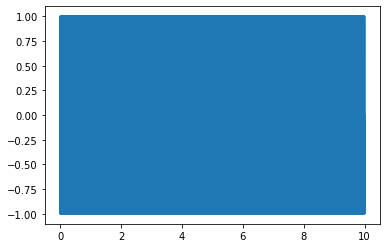

In [39]:
#continuos wave of 20Khz
sr=44100
f = 20000
t= np.linspace(0,10,10*sr)
X = np.sin(2*np.pi*f*t)
plt.plot(t,X)

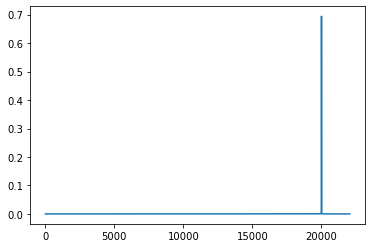

In [40]:
#FFT of continuos wave of 20Khz
F, A = compute_fft(X, sr, scale_amplitudes=True)
plt.plot(F[:], A[:])

C:\Users\Rishiraj\AppData\Local\Temp/ipykernel_18580/2650805311.py:2: UserWarning: shading value '' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(t, f, Sxx, shading='')


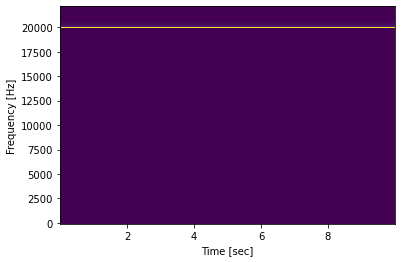

In [42]:
f, t, Sxx = signal.spectrogram(X, 44100)
plt.pcolormesh(t, f, Sxx, shading='')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.ylim(18000,20000)
plt.show()

In [19]:
#sf.write('1kHz_tone.wav', X, sr, 'PCM_24')

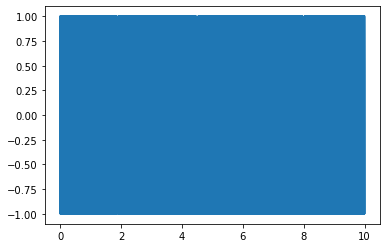

In [33]:
#file used to generate the frequency sweep
sr = 44100
t = np.linspace(0, 10, 10*sr)
X_chirp = signal.chirp(t, f0=18000, f1=20000, t1=10, method='linear')
plt.plot(t, X_chirp)

In [34]:
sf.write('18-20kHz_chirp.wav', X_chirp, sr, 'PCM_24')

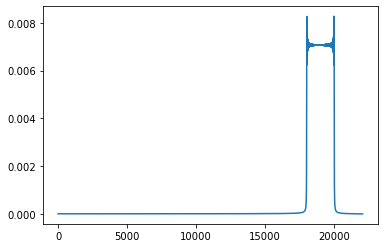

In [35]:
F, A = compute_fft(X_chirp, 44100, scale_amplitudes=True)
plt.plot(F[:], A[:])

C:\Users\Rishiraj\AppData\Local\Temp/ipykernel_18580/2235898591.py:2: UserWarning: shading value '' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(t, f, Sxx, shading='')


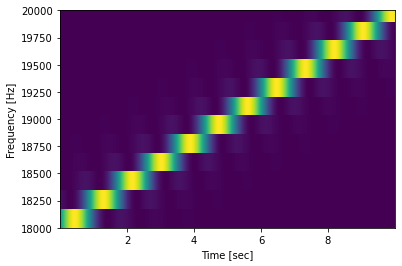

In [38]:
f, t, Sxx = signal.spectrogram(X_chirp, 44100)
plt.pcolormesh(t, f, Sxx, shading='')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(18000,20000)
plt.show()

In [36]:

#sf.write('18_20kHz_sweep.wav', w, 44100, 'PCM_24')

## Audio Recording Analysis Areana

## Spectogram of recordings

C:\Users\Rishiraj\AppData\Local\Temp/ipykernel_8296/3362575834.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load('data/smartphone/Chirp-indirect.m4a', sr=44100)


Number of sample in audio = 431104
Number of frames = 13469.0
Number of frequency components in a frame = 65.0


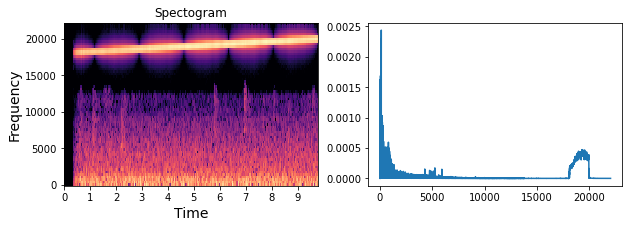

In [84]:
#Baseline spectogram
plotIndex = 0;
fig, ax = plt.subplots(1,2, figsize=(10,3))

x, fs = librosa.load('data/smartphone/Chirp-indirect.m4a', sr=44100)
t = np.arange(0,len(x))/fs
n_fft = 128
hop_length = n_fft//4 #the default value in librosa 
print("Number of sample in audio = {}".format(x.shape[0]))
print("Number of frames = {}".format((x.shape[0]-n_fft)/hop_length+1))
print("Number of frequency components in a frame = {}".format(n_fft/2+1))

S = np.abs(librosa.stft(x,hop_length=hop_length,n_fft=n_fft))

img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='linear', x_axis='time', ax=ax[0], sr=fs,hop_length=hop_length, n_fft=n_fft,win_length=n_fft)
ax[0].set_title('Spectogram')
ax[0].set_xlabel('Time',fontsize=14)
ax[0].set_ylabel('Frequency',fontsize=14)
#ax.set_ylim(0,8000)
#ax.set_xlim(0,20)

F, A = compute_fft(x, 44100, scale_amplitudes=True)
ax[1].plot(F[:], A[:])

## Multiplying Sent and Received Signal, output spectrogram

C:\Users\Rishiraj\AppData\Local\Temp/ipykernel_8296/2717692895.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  reflectedSignal,fs = librosa.load('data/smartphone/Chirp-indirect.m4a',sr=44100)


Reflected signal is not longer than source signal


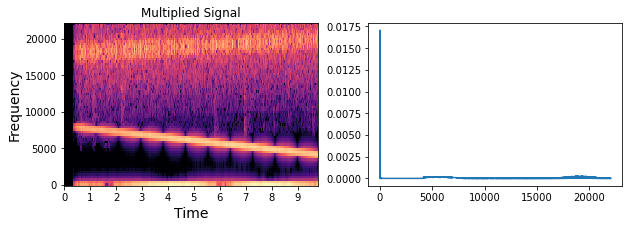

In [89]:
sourceSignal,fs = librosa.load('18-20kHz_chirp.wav', sr=44100)
reflectedSignal,fs = librosa.load('data/smartphone/Chirp-indirect.m4a',sr=44100)

#restrict reflected signal to the length of source signal
#we are doing this becuase the user takes some time to switch off the signal after the audio play is complete'
if sourceSignal.shape[0] < reflectedSignal.shape[0]:
    reflectedSignal = reflectedSignal[:sourceSignal.shape[0]]
else:
    sourceSignal = sourceSignal[:reflectedSignal.shape[0]]
    print("Reflected signal is not longer than source signal")
    
multipliedSignal = sourceSignal*reflectedSignal

#Spectrogram
fig, ax = plt.subplots(1,2, figsize=(10,3))
t = np.arange(0,len(multipliedSignal))/fs
n_fft = 128
hop_length = n_fft//4 #the default value in librosa 
S = np.abs(librosa.stft(multipliedSignal,hop_length=hop_length,n_fft=n_fft))
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='linear', x_axis='time', ax=ax[0], sr=fs,hop_length=hop_length, n_fft=n_fft,win_length=n_fft)
ax[0].set_title('Multiplied Signal')
ax[0].set_xlabel('Time',fontsize=14)
ax[0].set_ylabel('Frequency',fontsize=14)

F, A = compute_fft(multipliedSignal, 44100, scale_amplitudes=True)
ax[1].plot(F[1:], A[1:])

## Spectogram
### Emitter: Phone, Receiver: Boya Mic

Number of sample in audio = 549787
Number of frames = 1070.802734375
Number of frequency components in a frame = 1025.0


(0, 8000)

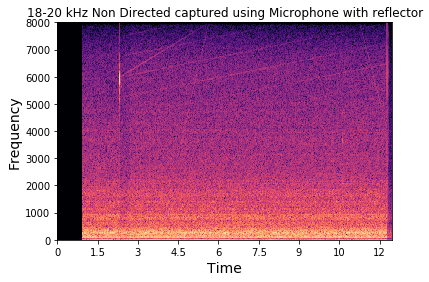

In [7]:
##20Khz sweep non-directed from one phone and captured in another phone in presence of reflector
plotIndex = 0;
fig, ax = plt.subplots(1,1)

x, fs = librosa.load('reflected-notebook-18-20kHz_chirp.wav', sr=44100)
t = np.arange(0,len(x))/fs
n_fft = 2048
hop_length = n_fft//4 #the default value in librosa 
print("Number of sample in audio = {}".format(x.shape[0]))
print("Number of frames = {}".format((x.shape[0]-n_fft)/hop_length+1))
print("Number of frequency components in a frame = {}".format(n_fft/2+1))

S = np.abs(librosa.stft(x,hop_length=hop_length,n_fft=n_fft))

img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='linear', x_axis='time', ax=ax, sr=fs,hop_length=hop_length, n_fft=n_fft,win_length=n_fft)
ax.set_title('18-20 kHz Non Directed captured using Microphone with reflector')
ax.set_xlabel('Time',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_ylim(0,8000)
#ax.set_xlim(0,20)